## Import packages

In [34]:
%reload_ext autoreload
%autoreload 2
from ripple_heterogeneity.utils import functions,loading,batch_analysis
from ripple_heterogeneity.ripple import pairwise_ccg_deep_sup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statannotations.Annotator import Annotator
from matplotlib.ticker import AutoMinorLocator
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

functions.set_plotting_defaults()

## get list of sessions and run analysis

In [30]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
df = functions.add_animal_id(df)
# not_to_use = (df["basepath"].str.contains("OMLproject", case=False)) | (
#     df["basepath"].str.contains("ORproject", case=False)
# )
# df = df.loc[~not_to_use]

In [31]:
df.animal_id.nunique()

# not_to_use = (df["basepath"].str.contains("OMLproject", case=False)) | (
#     df["basepath"].str.contains("ORproject", case=False)
# )
# df.nunique()

51

In [4]:
# df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

# not_to_use = (df["basepath"].str.contains("OMLproject", case=False)) | (
#     df["basepath"].str.contains("ORproject", case=False)
# )
# df = df.loc[~not_to_use]

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins_v2"
# without removing OR and OML

pairwise_ccg_deep_sup.run(df,save_path,parallel=True,states="wake")

In [35]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins_v3"

# batch_analysis.run(
#     df,
#     save_path,
#     pairwise_ccg_deep_sup.main,
#     parallel=True,
#     verbose=True,
# )

100%|██████████| 311/311 [07:21<00:00,  1.42s/it]


In [36]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_counts_par"
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins_v2"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins_v3"

ccgs, ccg_id_df = pairwise_ccg_deep_sup.load_results(save_path)


In [24]:
# not_to_use = ccg_id_df["basepath"].str.contains("OMLproject|ORproject", case=False)
# ccg_id_df = ccg_id_df.loc[~not_to_use]
# # ccgs = ccgs.iloc[:,~not_to_use]
# ccg_id_df

,ref,target,UID_ref,UID_target,deepSuperficial_ref,deepSuperficial_target,basepath,rho,pval,n_spikes_ref,n_spikes_target,layer_label,animal_id,rho_abs,rho_sq,constant,rho_trans
0,0,1,1,2,Deep,Superficial,Z:\Data\AYAold\AB1\day1,-0.009840,0.833481,NaN,NaN,cross_layer,AB1,0.009840,0.000097,1,-0.009486
1,0,2,1,9,Deep,middle,Z:\Data\AYAold\AB1\day1,-0.034177,0.465124,NaN,NaN,unknown,AB1,0.034177,0.001168,1,-0.030120
2,0,3,1,10,Deep,Superficial,Z:\Data\AYAold\AB1\day1,-0.025224,0.589871,NaN,NaN,cross_layer,AB1,0.025224,0.000636,1,-0.022972
3,0,4,1,12,Deep,middle,Z:\Data\AYAold\AB1\day1,-0.058894,0.207882,NaN,NaN,unknown,AB1,0.058894,0.003468,1,-0.047456
4,0,5,1,15,Deep,Superficial,Z:\Data\AYAold\AB1\day1,-0.048831,0.296512,NaN,NaN,cross_layer,AB1,0.048831,0.002384,1,-0.040801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190674,17,19,31,35,Deep,Deep,Z:\Data\Kenji\nlx_070329,0.077170,0.006934,NaN,NaN,same_layer,nlx,0.077170,0.005955,1,0.103543
190675,17,20,31,41,Deep,middle,Z:\Data\Kenji\nlx_070329,0.124600,0.000012,NaN,NaN,unknown,nlx,0.124600,0.015525,1,0.201172
190676,18,19,32,35,Deep,Deep,Z:\Data\Kenji\nlx_070329,0.019875,0.487418,NaN,NaN,same_layer,nlx,0.019875,0.000395,1,0.021416
190677,18,20,32,41,Deep,middle,Z:\Data\Kenji\nlx_070329,-0.025193,0.378709,NaN,NaN,unknown,nlx,0.025193,0.000635,1,-0.022946


## add layer comparison label

In [37]:
ccg_id_df['layer_label'] = 'unknown'

idx = (ccg_id_df.deepSuperficial_ref == 'Deep') & (ccg_id_df.deepSuperficial_target == 'Deep')
ccg_id_df.loc[idx,'layer_label'] = 'same_layer'
idx = (ccg_id_df.deepSuperficial_ref == 'Superficial') & (ccg_id_df.deepSuperficial_target == 'Superficial')
ccg_id_df.loc[idx,'layer_label'] = 'same_layer'

idx = (ccg_id_df.deepSuperficial_ref == 'Deep') & (ccg_id_df.deepSuperficial_target == 'Superficial')
ccg_id_df.loc[idx,'layer_label'] = 'cross_layer'
idx = (ccg_id_df.deepSuperficial_ref == 'Superficial') & (ccg_id_df.deepSuperficial_target == 'Deep')
ccg_id_df.loc[idx,'layer_label'] = 'cross_layer'

## add animal id

In [38]:
ccg_id_df["animal_id"] = ccg_id_df.basepath.map(
    dict(
        [
            (basepath, loading.get_animal_id(basepath))
            for basepath in ccg_id_df.basepath.unique()
        ]
    )
)

In [25]:
# ccg_id_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_counts_par_id_df.csv")

## plot correlation

In [39]:
ccg_id_df["rho_abs"] = np.abs(ccg_id_df.rho)
ccg_id_df["rho_sq"] = ccg_id_df.rho**2

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_same_layer vs. 1_cross_layer: Mann-Whitney-Wilcoxon test two-sided, P_val:8.933e-02 U_stat=1.372e+09


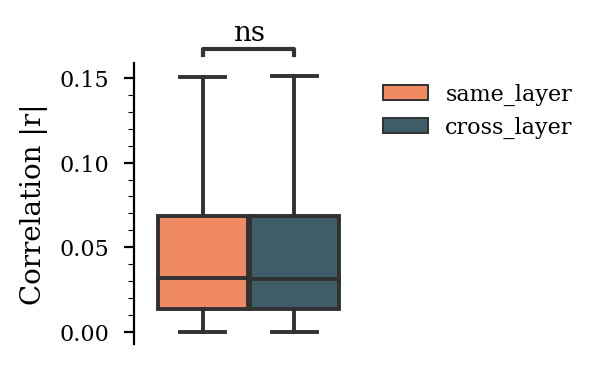

In [40]:
group_colors = {"same_layer": "#ef8a62", "cross_layer": "#3e5d66"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(2, 1)), edgecolor="k"
)
axs = plt.gca()
ccg_id_df["constant"] = 1
g=sns.boxplot(
    x="constant",
    y="rho_abs",
    hue="layer_label",
    data=ccg_id_df,
    showfliers=False,
    hue_order=group_colors.keys(),
    saturation=1
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
sns.despine(bottom=True)
# plt.axhline(0, color="grey", linestyle="--", zorder=-100)
# plt.yscale("log")
plt.ylabel("Correlation |r|")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
g.set(xlabel=None)
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().axes.get_xaxis().set_ticks([])
# plt.yscale("log")
box_pairs = [
    ((1, "same_layer"), (1, "cross_layer")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=ccg_id_df,
    x="constant",
    y="rho_abs",
    hue="layer_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
# plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_corr_deep_sup_v2.svg'),dpi=300,bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_same_layer vs. 1_cross_layer: Mann-Whitney-Wilcoxon test two-sided, P_val:8.138e-02 U_stat=1.372e+09


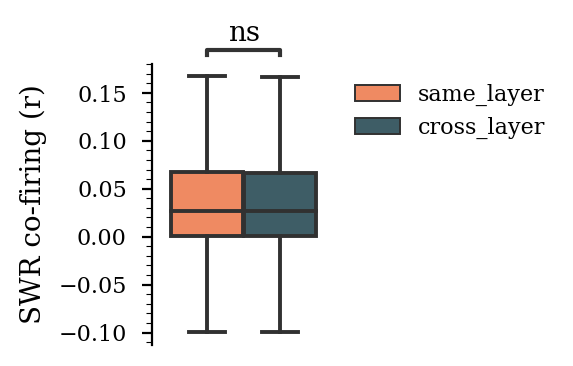

In [41]:
from scipy.stats import boxcox
group_colors = {"same_layer": "#ef8a62", "cross_layer": "#3e5d66"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2.5, 1)), edgecolor="k"
)
axs = plt.gca()
ccg_id_df["constant"] = 1

# ccg_id_df["rho_trans"] = boxcox(ccg_id_df.rho+1)[0]

g=sns.boxplot(
    x="constant",
    y="rho",
    hue="layer_label",
    data=ccg_id_df,
    showfliers=False,
    hue_order=group_colors.keys(),
    saturation=1
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
sns.despine(bottom=True)
# plt.axhline(0, color="grey", linestyle="--", zorder=-100)
# plt.yscale("log")
plt.ylabel("SWR co-firing (r)")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
g.set(xlabel=None)
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().axes.get_xaxis().set_ticks([])
# plt.yscale("log")
box_pairs = [
    ((1, "same_layer"), (1, "cross_layer")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=ccg_id_df,
    x="constant",
    y="rho",
    hue="layer_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
# plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_corr_deep_sup_v3.svg'),dpi=300,bbox_inches='tight')
plt.show()

In [42]:
print(ccg_id_df.query("layer_label.str.contains('cross_layer|same_layer')").animal_id.nunique())

print(ccg_id_df.query("layer_label.str.contains('cross_layer|same_layer')").size)

ccg_id_df.groupby("layer_label").rho.median()

49
1869200


layer_label
cross_layer    0.026364
same_layer     0.026996
unknown        0.028569
Name: rho, dtype: float64

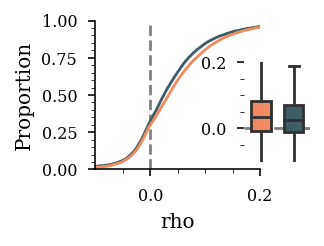

In [9]:
from ripple_heterogeneity.utils import custom_plots

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}
sns.set_palette(sns.color_palette(group_colors.values()))


fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1.5, 1)), edgecolor='k')
axs = plt.gca()

box_ax = custom_plots.plot_ecdf_box(
    data=ccg_id_df,
    x="rho",
    hue="layer_label",
    hue_order=group_colors.keys(),
    x_offset=0.7,
    y_offset=0.04,
    showfliers=False,
    ax=axs,
    fig=fig)
axs.set_xlim(-0.1, .2)
box_ax.set_ylim(-0.1, .2)
axs.axvline(0, color='grey', linestyle='--',zorder=-100)
box_ax.axhline(0, color='grey', linestyle='--',zorder=-100)

# plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_corr_deep_sup.svg'),dpi=300,bbox_inches='tight')


## mean of z-score

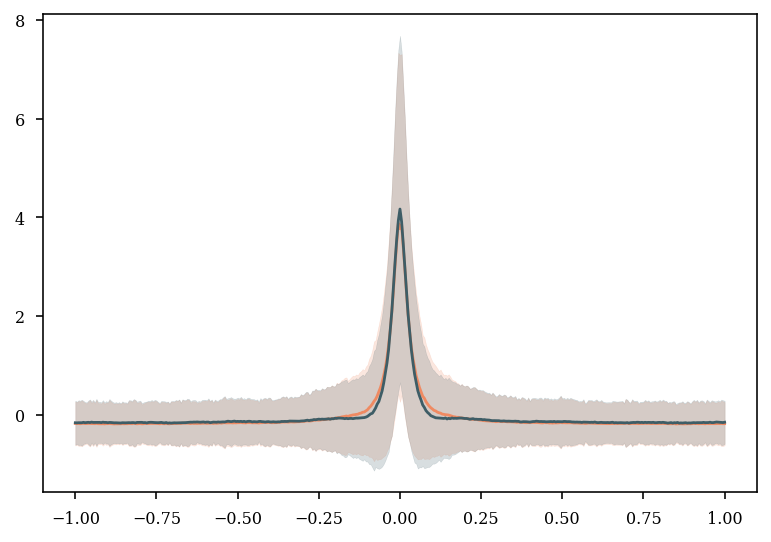

In [65]:
from scipy.stats import zscore

ccgs_z = zscore(ccgs, axis=0)

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

idx = ccg_id_df.layer_label == "same_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
std = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = ccg_id_df.layer_label == "cross_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
sem = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)

plt.show()

In [ ]:
# temp_ccg_df = ccg_id_df[ccg_id_df.basepath == "Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_10252013"]
# temp_ccgs_z = ccgs_z.loc[:,ccg_id_df.basepath == "Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_10252013"]

# WINDOW = 30

# idx = temp_ccg_df.layer_label == "same_layer"
# ccg_smooth = gaussian_filter1d(temp_ccgs_z.loc[:,idx],WINDOW,axis=1)
# x = temp_ccgs_z.index
# std = np.nanstd(ccg_smooth,axis=1)
# plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

# idx = temp_ccg_df.layer_label == "cross_layer"
# ccg_smooth = gaussian_filter1d(temp_ccgs_z.loc[:,idx],WINDOW,axis=1)
# y = np.nanmean(ccg_smooth,axis=1)
# x = temp_ccgs_z.index
# sem = np.nanstd(ccg_smooth,axis=1)
# plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)
# plt.legend()
# plt.show()

## normalize by subtracting slow component 

In [68]:
def get_z_transform(ccgs):
    """    
    """
    z = []
    for ccg in ccgs.values.T:
        ccg_smooth = gaussian_filter1d(ccg,30)
        z.append((ccg - ccg_smooth) / np.sqrt(ccg_smooth))
    ccgs_out = ccgs.copy()    
    ccgs_out[:] = np.vstack(z).T
    return ccgs_out

ccgs_z = get_z_transform(ccgs)

C:\Users\Cornell\AppData\Local\Temp\ipykernel_25196\3527765283.py:7: RuntimeWarning: invalid value encountered in true_divide


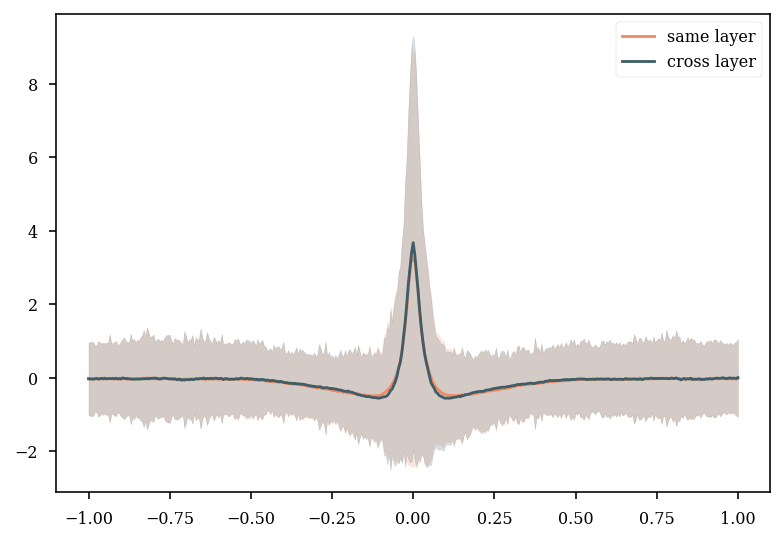

In [69]:
group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

idx = ccg_id_df.layer_label == "same_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
std = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = ccg_id_df.layer_label == "cross_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
sem = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)
plt.legend()
plt.show()

## Mean raw ccg -.2 to .2 sec

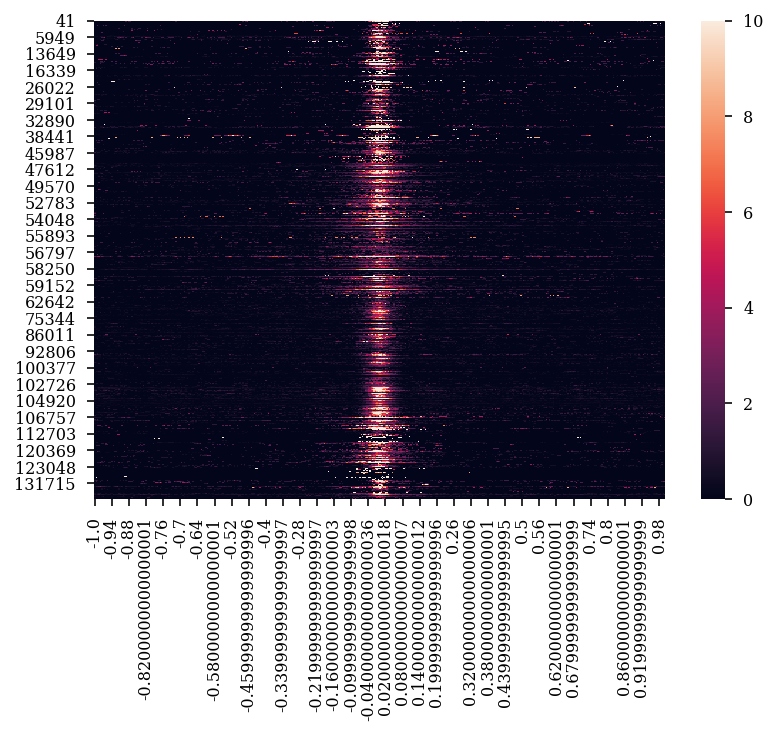

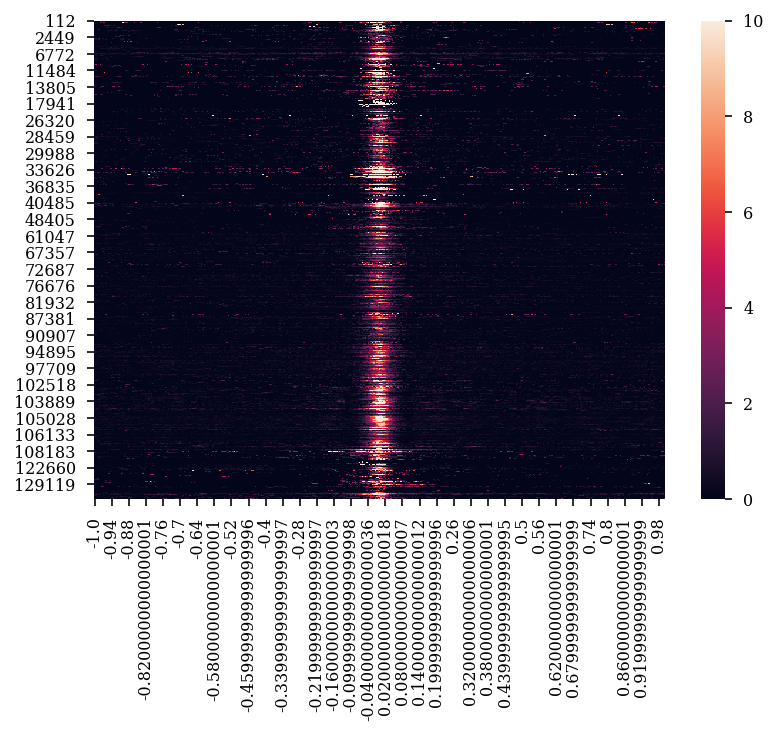

In [72]:
idx = (ccg_id_df.layer_label == "same_layer") & (ccg_id_df.pval < 0.05)
sns.heatmap(ccgs.loc[:,idx].T,vmax=10)
plt.show()

idx = (ccg_id_df.layer_label == "cross_layer") & (ccg_id_df.pval < 0.05)
sns.heatmap(ccgs.loc[:,idx].T,vmax=10)
plt.show()


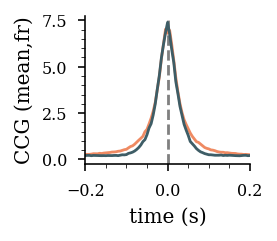

In [94]:
from matplotlib.ticker import AutoMinorLocator

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1.5, 1)), edgecolor='k')

idx = (ccg_id_df.layer_label == "same_layer") & (ccg_id_df.pval < 0.05)
y = np.nanmean(ccgs.loc[:,idx],axis=1)
x = ccgs.index
std = np.nanstd(ccgs.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = (ccg_id_df.layer_label == "cross_layer") & (ccg_id_df.pval < 0.05)
y = np.nanmean(ccgs.loc[:,idx],axis=1)
x = ccgs.index
sem = np.nanstd(ccgs.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)
plt.xlim(-.2,.2)
plt.axvline(0, color='grey', linestyle='--',zorder=-100)
plt.ylabel('CCG (mean,fr)')
plt.xlabel('time (s)')
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_ccg_deep_sup.svg'),dpi=300,bbox_inches='tight')
# plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_ccg_deep_sup.jpeg'),dpi=300,bbox_inches='tight')


In [ ]:
idx = (ccg_id_df.layer_label == "same_layer") & (ccg_id_df.pval < 0.05)
sns.heatmap(ccgs.loc[:,idx].T,vmax=10)
plt.show()

In [121]:
ccg_id_df[ccg_id_df.basepath.str.contains("day17")]


,ref,target,UID_ref,UID_target,deepSuperficial_ref,deepSuperficial_target,basepath,rho,pval,layer_label,animal_id,rho_abs,rho_sq,constant
27080,0,1,25,26,Superficial,Superficial,Z:\Data\AYAold\AYA6\day17,-0.002780,8.988868e-01,same_layer,AYA6,0.002780,0.000008,1
27081,0,2,25,27,Superficial,Deep,Z:\Data\AYAold\AYA6\day17,0.019697,3.678878e-01,cross_layer,AYA6,0.019697,0.000388,1
27082,0,3,25,28,Superficial,middle,Z:\Data\AYAold\AYA6\day17,0.103420,2.135731e-06,unknown,AYA6,0.103420,0.010696,1
27083,0,4,25,29,Superficial,Superficial,Z:\Data\AYAold\AYA6\day17,0.034672,1.128855e-01,same_layer,AYA6,0.034672,0.001202,1
27084,0,5,25,30,Superficial,Superficial,Z:\Data\AYAold\AYA6\day17,0.180499,8.854613e-17,same_layer,AYA6,0.180499,0.032580,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39173,46,48,97,101,middle,middle,Z:\Data\AYAold\AYA9\day17,-0.023090,4.492737e-01,unknown,AYA9,0.023090,0.000533,1
39174,46,49,97,104,middle,middle,Z:\Data\AYAold\AYA9\day17,0.029159,3.392855e-01,unknown,AYA9,0.029159,0.000850,1
39175,47,48,100,101,middle,middle,Z:\Data\AYAold\AYA9\day17,0.001505,9.606618e-01,unknown,AYA9,0.001505,0.000002,1
39176,47,49,100,104,middle,middle,Z:\Data\AYAold\AYA9\day17,0.083432,6.174718e-03,unknown,AYA9,0.083432,0.006961,1


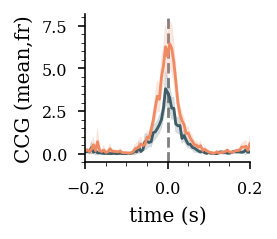

In [129]:

def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper

basepath = "Z:\Data\AYAold\AYA9\day17"

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1.5, 1)), edgecolor='k')

idx = (ccg_id_df.layer_label == "cross_layer") & (ccg_id_df.basepath == basepath)

y = np.nanmean(ccgs.loc[:,idx],axis=1)
x = ccgs.index
sem = np.nanstd(ccgs.loc[:,idx],axis=1)
lower,upper = confidence_intervals(ccgs.loc[:,idx].values.T)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
plt.fill_between(x, lower, upper,color=group_colors['cross_layer'] ,alpha=0.2)


idx = (ccg_id_df.layer_label == "same_layer") & (ccg_id_df.basepath == basepath)
y = np.nanmean(ccgs.loc[:,idx],axis=1)
x = ccgs.index
sem = np.nanstd(ccgs.loc[:,idx],axis=1)
lower,upper = confidence_intervals(ccgs.loc[:,idx].values.T)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
plt.fill_between(x, lower, upper,color=group_colors['same_layer'] ,alpha=0.2)
plt.xlim(-.2,.2)
plt.axvline(0, color='grey', linestyle='--',zorder=-100)
plt.ylabel('CCG (mean,fr)')
plt.xlabel('time (s)')
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# plt.show()
plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_ccg_deep_sup_single_session_example.svg'),dpi=300,bbox_inches='tight')


In [145]:
# idx = (ccg_id_df.layer_label == "same_layer") & (ccg_id_df.basepath == basepath)
# y = np.nanmean(ccgs.loc[:,idx],axis=1)
# x = ccgs.index
# plt.plot(ccgs.loc[:,idx],color=group_colors['same_layer'],label='cross layer',alpha=1,linewidth=.05)
# plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
# plt.ylim(-.01,8)
# plt.xlim(-.2,.2)

# plt.show()

In [ ]:
from scipy import stats

def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper

for basepath in ccg_id_df.basepath.unique():
    # plt.plot(ccgs.loc[:,(ccg_id_df.basepath == basepath) & (ccg_id_df.layer_label == "same_layer")].mean(axis=1),color=group_colors['same_layer'])
    # plt.plot(ccgs.loc[:,(ccg_id_df.basepath == basepath) & (ccg_id_df.layer_label == "cross_layer")].mean(axis=1),color=group_colors['cross_layer'])
    # plt.title(basepath)

    idx = (ccg_id_df.layer_label == "cross_layer") & (ccg_id_df.basepath == basepath)

    y = np.nanmean(ccgs.loc[:,idx],axis=1)
    x = ccgs.index
    sem = np.nanstd(ccgs.loc[:,idx],axis=1)
    lower,upper = confidence_intervals(ccgs.loc[:,idx].values.T)
    plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
    plt.fill_between(x, lower, upper,color=group_colors['cross_layer'] ,alpha=0.2)


    idx = (ccg_id_df.layer_label == "same_layer") & (ccg_id_df.basepath == basepath)
    y = np.nanmean(ccgs.loc[:,idx],axis=1)
    x = ccgs.index
    sem = np.nanstd(ccgs.loc[:,idx],axis=1)
    lower,upper = confidence_intervals(ccgs.loc[:,idx].values.T)
    plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
    plt.fill_between(x, lower, upper,color=group_colors['same_layer'] ,alpha=0.2)
    plt.xlim(-.5,.5)
    plt.title(basepath)

    plt.show()


161